#### PCA tomography on combined spectra

In [1]:
import json
from pca_cleaning import SpectralPCA
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS

In [2]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

import numpy as np
from astropy.io import fits
from astropy.wcs import WCS


def get_wl(filename, redshift):
    # Abrir o arquivo FITS e obter o cabeçalho e os dados
    header = fits.getheader(filename, ext=("sci", 1))
    data = fits.getdata(filename, ext=("sci", 1))

    # Criar o objeto WCS a partir do cabeçalho
    wcs = WCS(header, naxis=[1])

    # Obter o número de pixels na dimensão espectral (assumindo que está no eixo 1)
    num_pixels = data.shape[1]

    # Gerar a sequência de pixels e convertê-los para comprimentos de onda
    wavelength = wcs.wcs_pix2world(np.arange(num_pixels), 0)[0]

    # Aplicar a correção do redshift
    corrected_wl = wavelength / (1 + redshift)

    return corrected_wl

In [27]:
# This function is designed to aid the creation of a emission line mask.
# It plots the sum of all spectra and other 10 points of the IFU, showing where we are making cuts


def inspect_velocity_redshift_emission(
    source,
    wl,
    mdf,
    emission_lines: list,
    delta,
):
    beams = [408, 419, 69, 269, 469, 669, 658, 458, 258, 58]
    nbeamplots = len(beams)  # number of beams to plot
    nplots = (
        nbeamplots + 1
    )  # total number of plots is the number of beams selected + 1 (the first plot is the sum of all beams)
    plot_heigth = nplots * 5
    fig, ax = plt.subplots(
        nrows=nplots, ncols=1, figsize=(60, plot_heigth), sharex=False
    )

    # Define a granularidade de marcações no eixo x
    xticks = np.arange(wl.min(), wl.max(), 100)

    signal = np.nansum(source, axis=0)
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    ax[0].plot(wl, np.clip(signal, None, signal_mean + 2.5 * signal_std))
    ax[0].set_title("Sum of all spectra")
    ax[0].set_xticks(xticks)

    # Make a lookup table from the MDF to know which row in the matrix represent each beam
    mdf_table = Table(mdf)
    source_mdf = mdf_table[mdf_table["BEAM"] == 1]
    target_beams_mdf = source_mdf[np.isin(source_mdf["NO"], beams)]

    for beam_seq, beam_id in enumerate(beams):
        beam_row_index = np.where(target_beams_mdf["NO"] == beam_id)[0]
        plot_index = beam_seq + 1
        ax[plot_index].plot(wl, source[beam_row_index].flatten())  # Garantir que é 1D
        ax[plot_index].set_title(f"Signal of beam {beam_id}")
        ax[plot_index].set_xticks(xticks)

    for line_wl in emission_lines:
        for figure in ax:
            figure.axvline(line_wl - delta, ls="dashed", color="red", lw=0.6)
            figure.axvline(line_wl + delta, ls="dashed", color="orange", lw=0.6)

    plt.show()

In [28]:
def emission_masker(input_signal, wl, emission_lines, delta_lambda):
    # Máscara para remover linhas de emissão do espectro
    masked_signal = np.copy(input_signal)
    for line in emission_lines:
        mask = (wl >= (line - delta_lambda)) & (wl <= (line + delta_lambda))
        masked_signal = np.where(mask, np.nan, masked_signal)

    return masked_signal


def inspect_velocity_redshift_absortion(
    source,
    wl,
    mdf,
    emission_lines,
    delta_lambda,
    absortion_windows,
    *args,
    **kwargs,
):
    beams = [408, 419, 69, 269, 469, 669, 658, 458, 258, 58]
    nbeamplots = len(beams)  # number of beams to plot
    nplots = (
        nbeamplots + 1
    )  # total number of plots is the number of beams selected + 1 (the first plot is the sum of all beams)
    plot_heigth = nplots * 5
    fig, ax = plt.subplots(
        nrows=nplots, ncols=1, figsize=(60, plot_heigth), sharex=True
    )

    signal = np.nansum(source, axis=0)
    masked_signal = emission_masker(signal, wl, emission_lines, delta_lambda)
    # ax[0].plot(wl, np.clip(masked_signal, None, None))
    ax[0].plot(wl, masked_signal)
    ax[0].set_title("Sum of all spectra")

    # Make a lookup table from the MDF to know which row in the matrix represent each beam
    mdf_table = Table(mdf)
    source_mdf = mdf_table[mdf_table["BEAM"] == 1]
    target_beams_mdf = source_mdf[np.isin(source_mdf["NO"], beams)]
    for beam_seq, beam_id in enumerate(beams):
        beam_row_index = np.where(target_beams_mdf["NO"] == beam_id)[0]
        plot_index = beam_seq + 1

        signal = source[beam_row_index].flatten()
        masked_signal = emission_masker(signal, wl, emission_lines, delta_lambda)
        ax[plot_index].plot(wl, masked_signal)
        ax[plot_index].set_title(f"Signal of beam {beam_id}")

    for abs_window in absortion_windows:
        for figure in ax:
            figure.axvline(abs_window[0], ls="dashed", color="black", lw=0.6)
            figure.axvline(abs_window[1], ls="dashed", color="gray", lw=0.6)

    plt.show()

### GSN 069

In [30]:
observed_absortion_windows = [
    (4124, 4150),
    (4282, 4317),
    (4370, 4421),
    (4515, 4592),
    (5028, 5050),
    (5070, 5135),
    (5161, 5193),
    (5247, 5287),
    (5314, 5354),
    (5390, 5417),
    (5698, 5722),
    (5938, 5995),
    (6050, 6073),
]

In [40]:
object_name = list(sci_files_object_mapping.keys())[1]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_combined_spectra_ext.fits"
print(filename)
redshift = 0.018

with fits.open(filename) as hdul:
    science = hdul["SCI"].data
    mdf = hdul["MDF"].data

wl = get_wl(filename, redshift)

redux/gsn069_combined_spectra_ext.fits


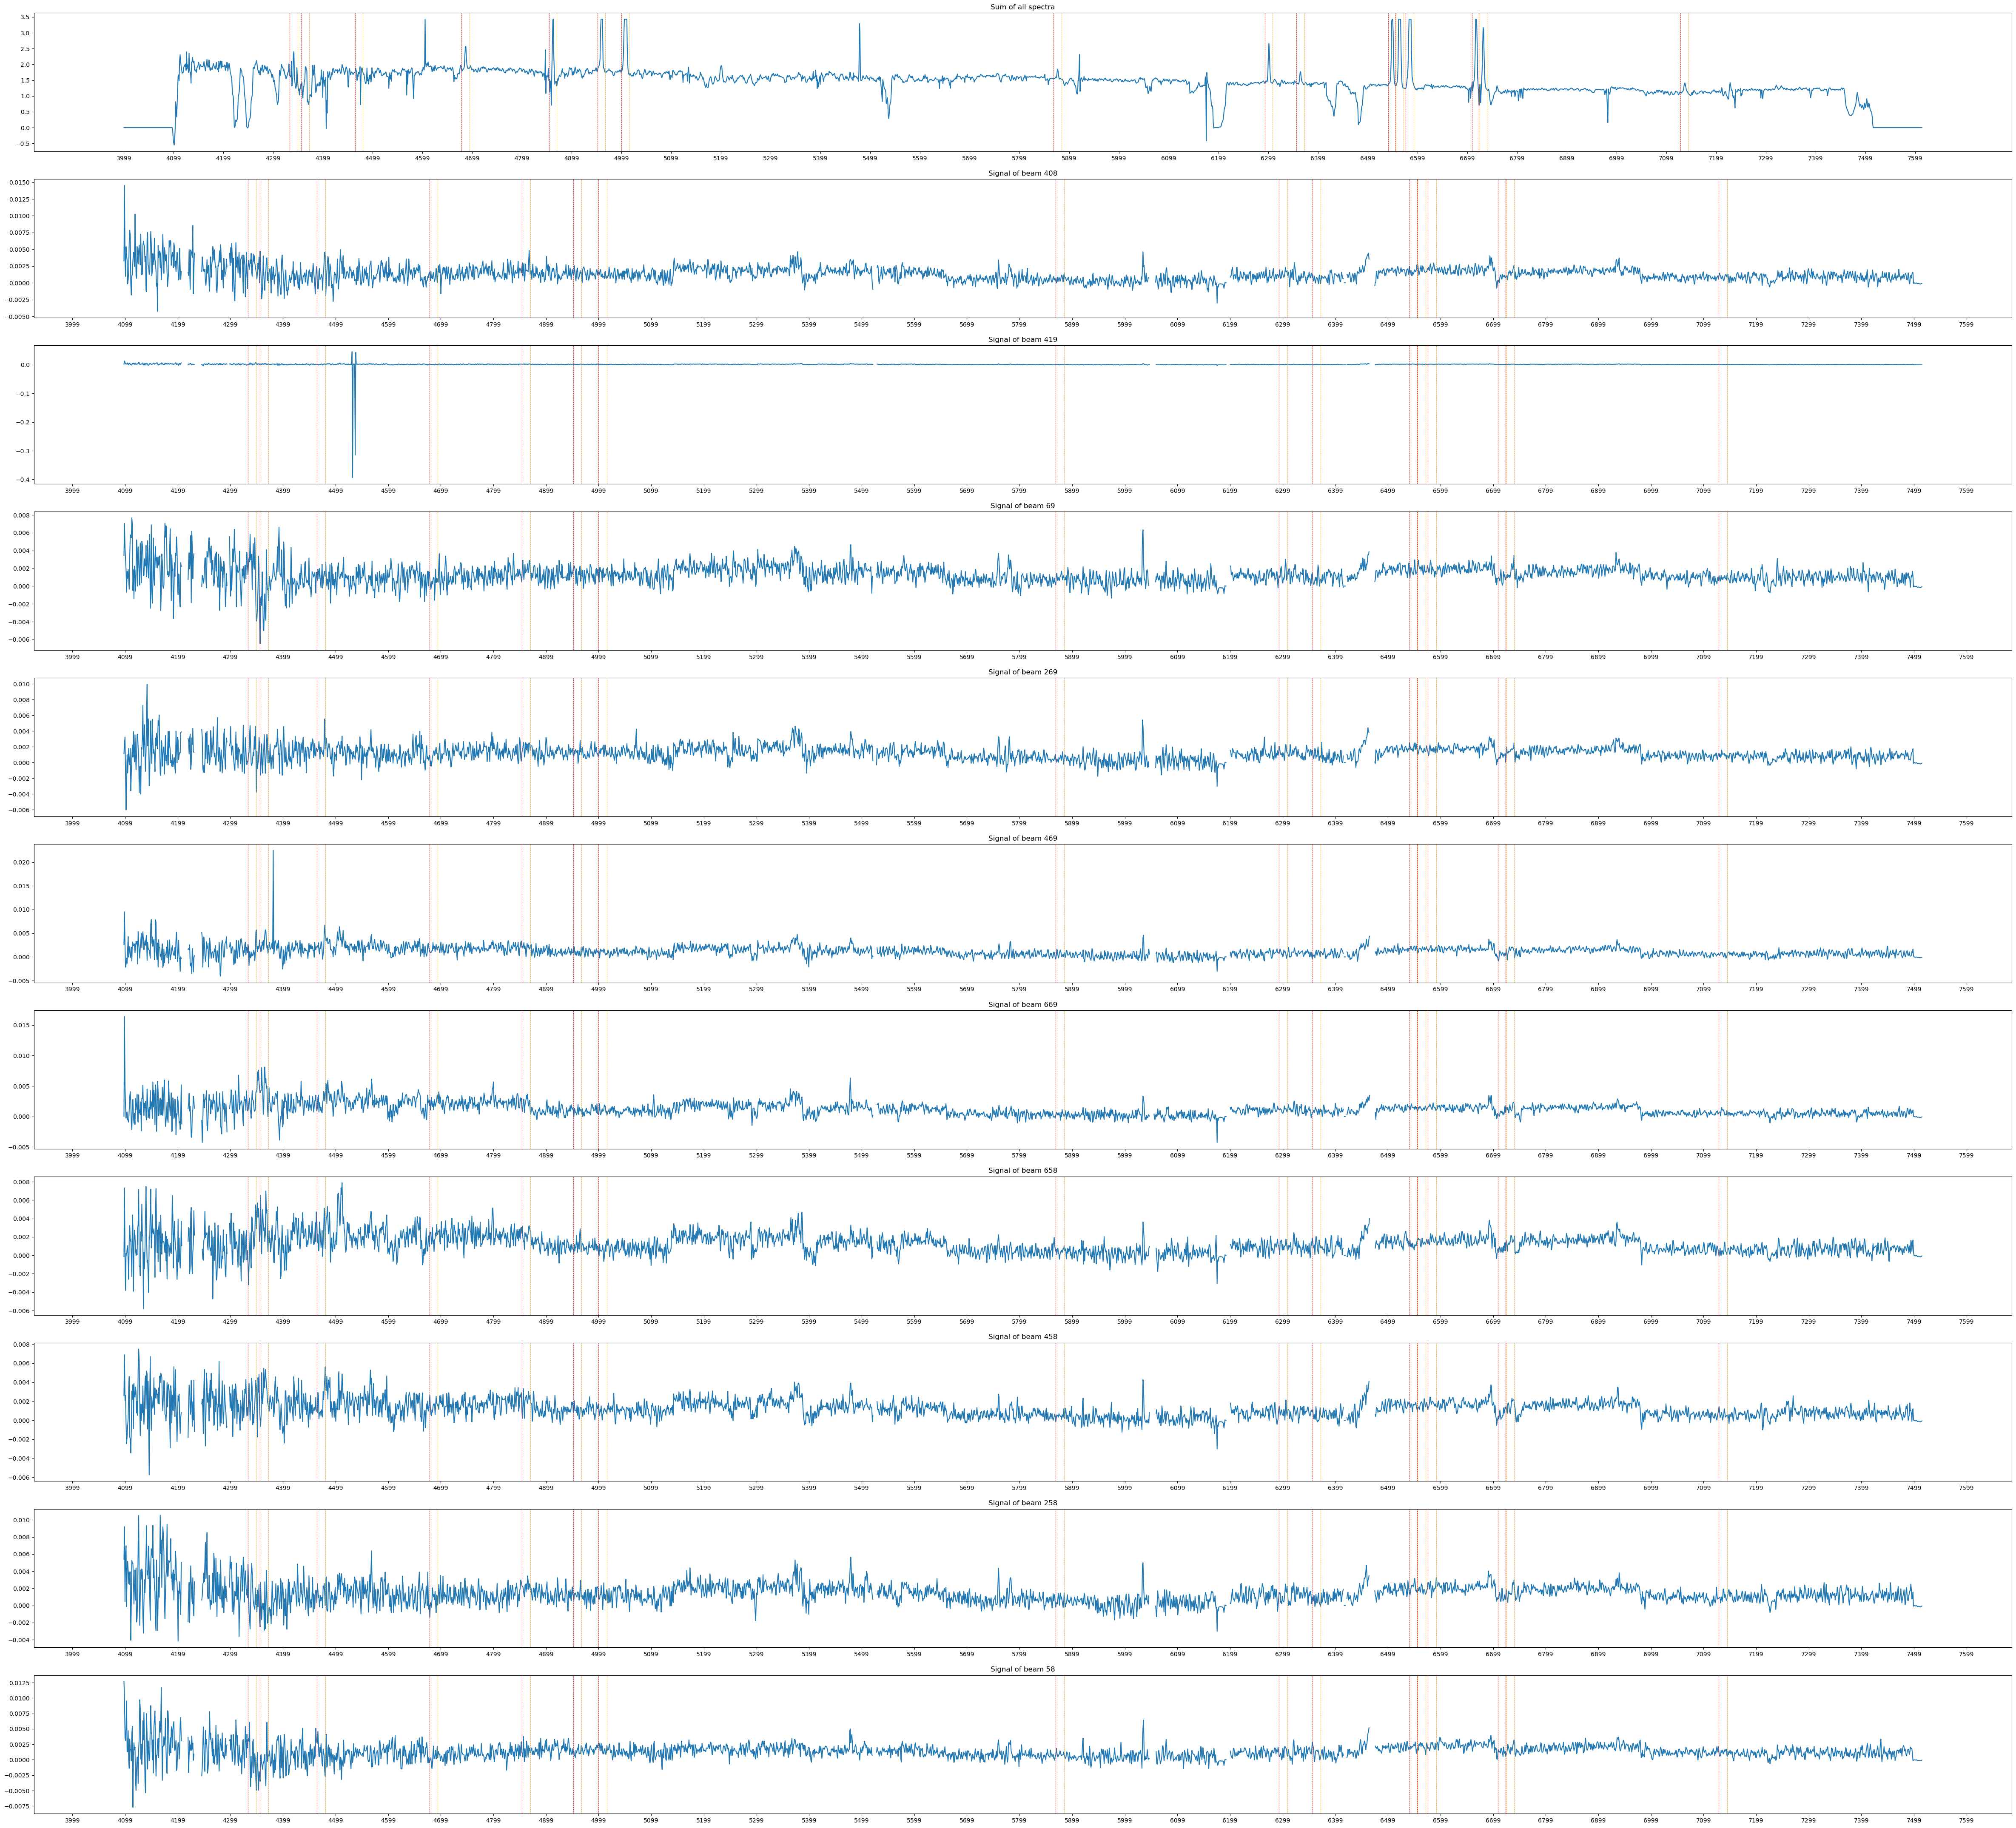

In [41]:
delta = 8

emission_lines = [
    4340.46,  # Hγ
    4363.21,  # [O III]
    4471.5,  # He I
    4685.68,  # He II
    4861.33,  # Hβ
    4958.91,  # [O III]
    5006.84,  # [O III]
    5875.6,  # He I
    6300.30,  # [O I]
    6363.78,  # [O I]
    6548.05,  # [N II]
    6562.79,  # Hα
    6583.45,  # [N II]
    6716.44,  # [S II]
    6730.82,  # [S II]
    7135.8,  # [Ar III]
]

inspect_velocity_redshift_emission(science, wl, mdf, emission_lines, delta)

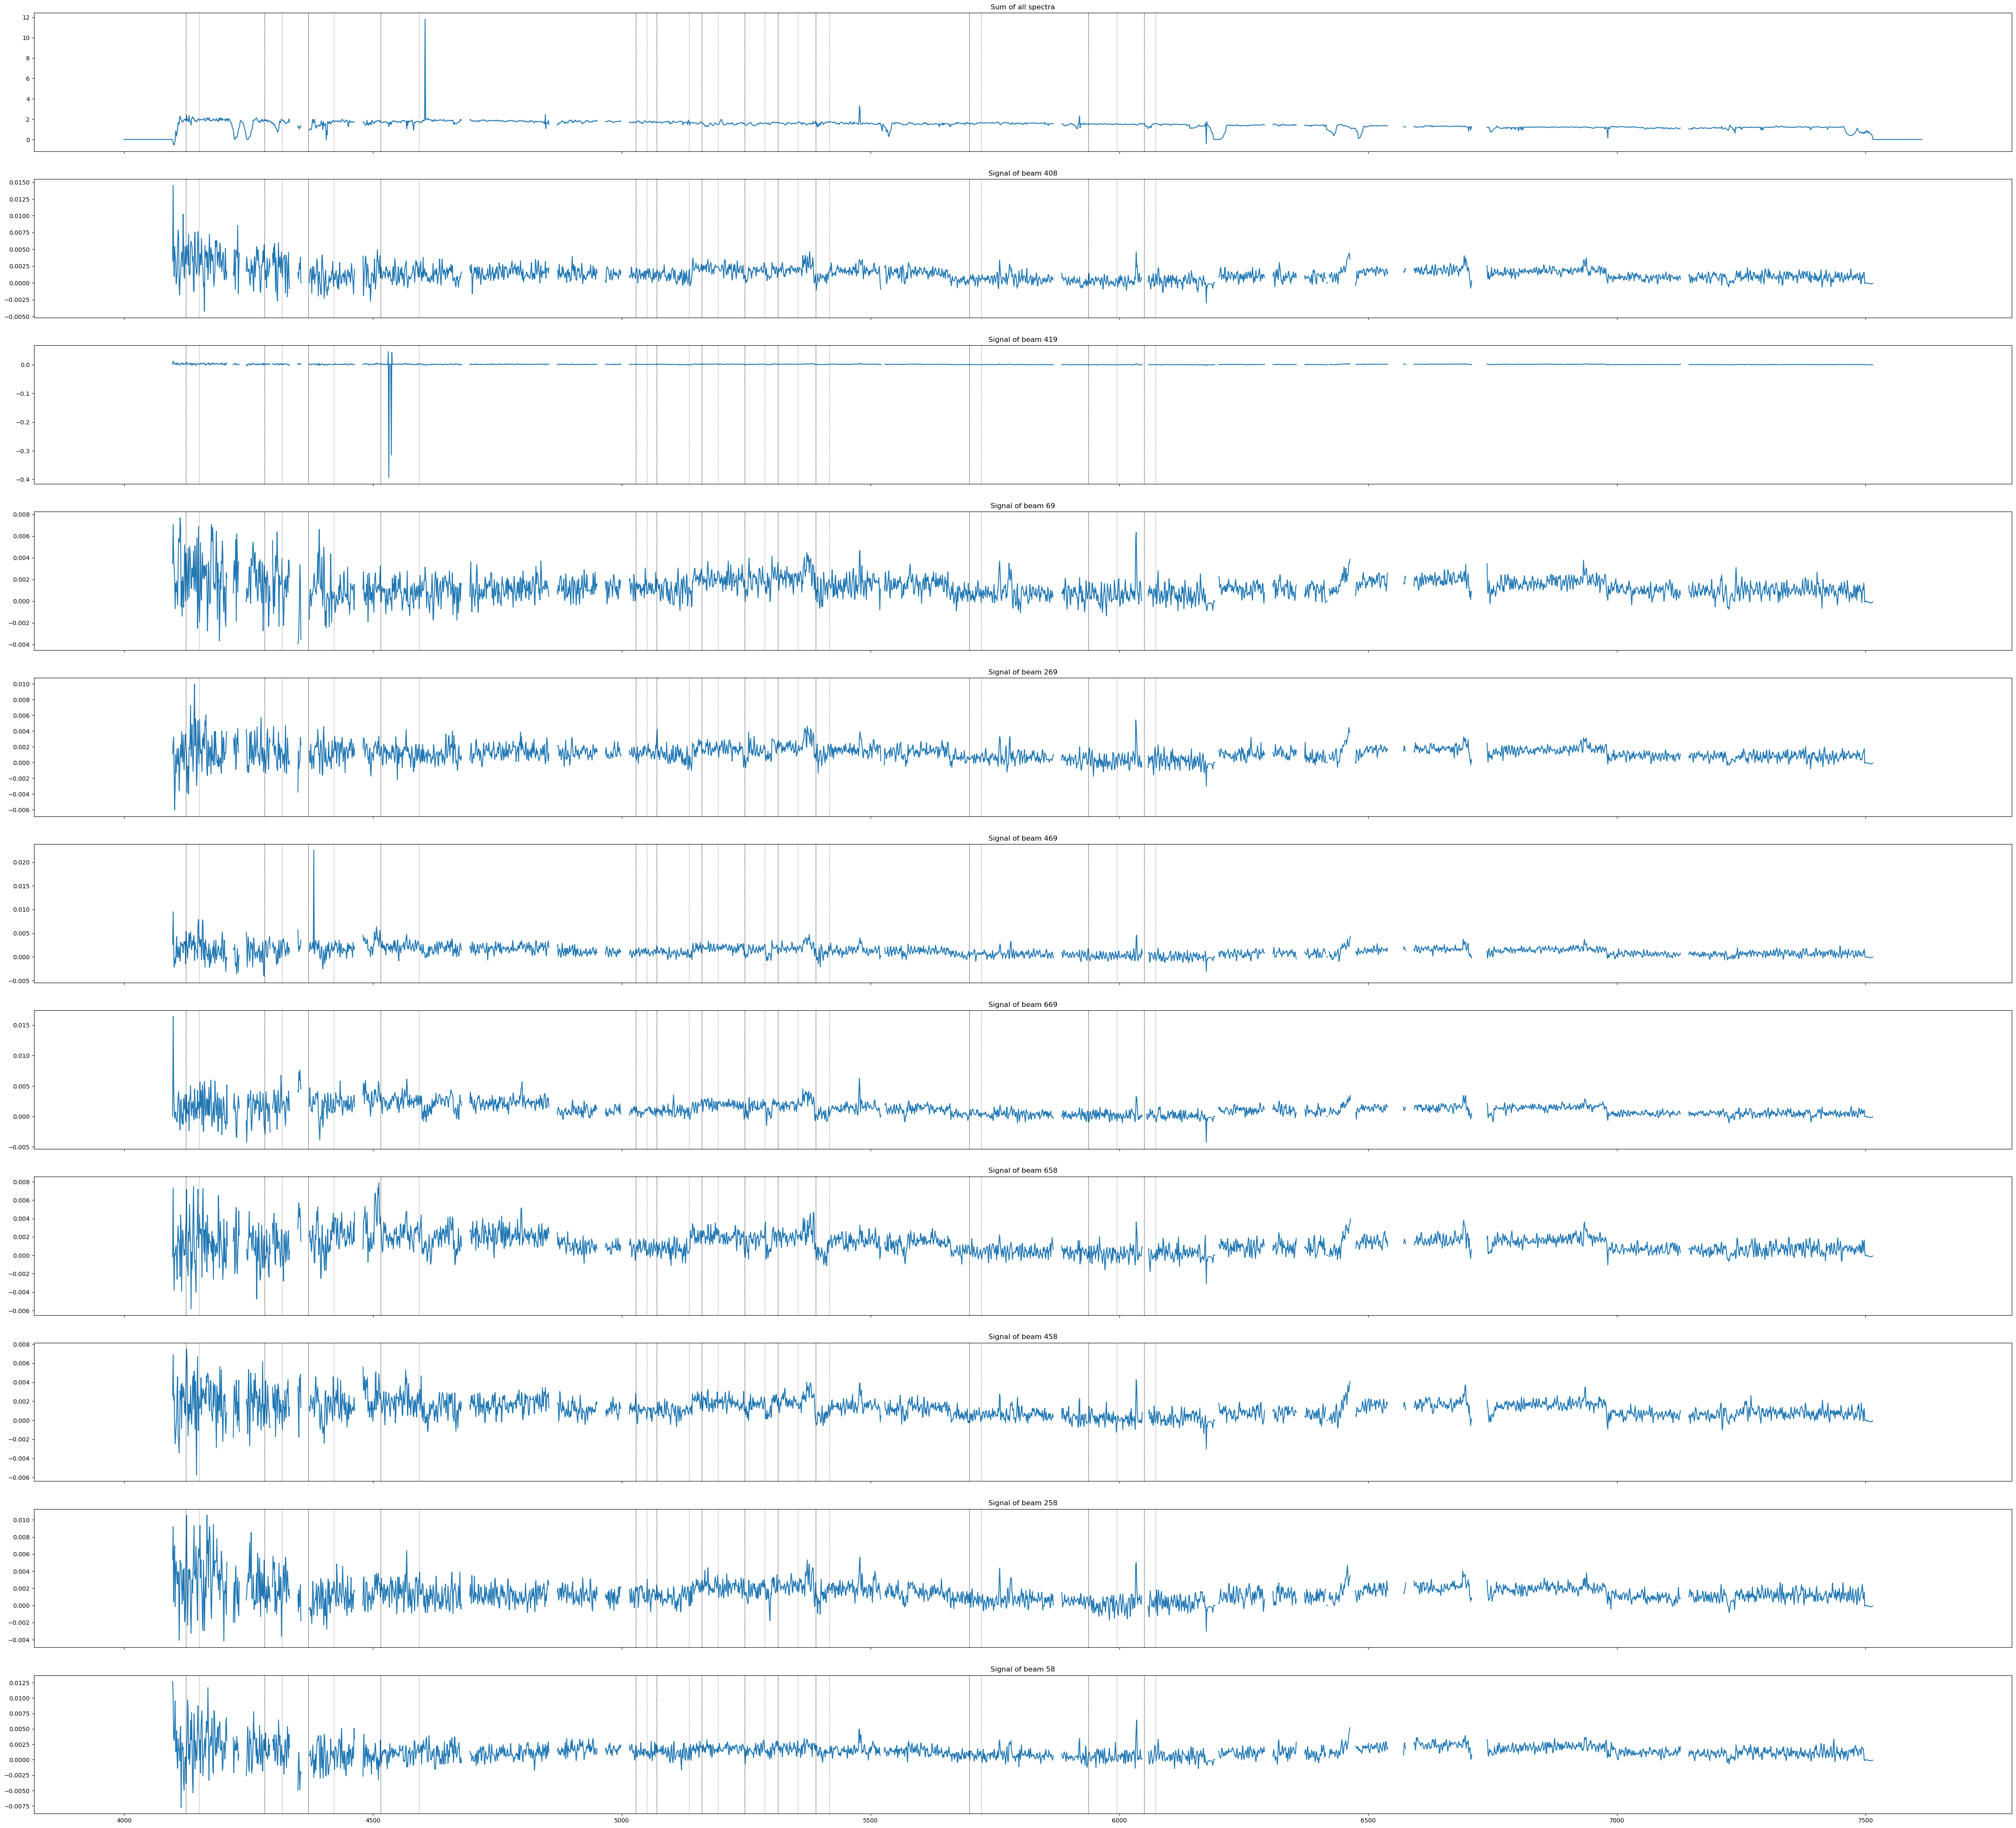

In [42]:
absortion_windows = [
    (4124, 4150),
    (4282, 4317),
    (4370, 4421),
    (4515, 4592),
    (5028, 5050),
    (5070, 5135),
    (5161, 5193),
    (5247, 5287),
    (5314, 5354),
    (5390, 5417),
    (5698, 5722),
    (5938, 5995),
    (6050, 6073),
]


inspect_velocity_redshift_absortion(
    science, wl, mdf, emission_lines, delta, absortion_windows
)

In [43]:
pca_selection_criteria = "selection_index"


data = SpectralPCA(
    filename,
    redshift,
    emission_lines,
    delta,
    observed_absortion_windows,
)


data.pca_decompose()


data.luminosity_component_correlation(pca_selection_criteria)

x2     17279.385483
x3       283.122700
x1       211.589094
x4        29.372374
x6         3.264835
x14        1.286154
x9         0.941057
x15        0.259297
x16        0.209598
x5         0.168049
x8         0.135113
x10        0.129330
x17        0.127045
x7         0.081890
x13        0.074876
x18        0.046973
x19        0.045540
x11        0.033977
x20        0.001145
x12        0.000252
Name: selection_index, dtype: float64


In [44]:
selection_threshold = 0.08
data.subtract_bad_components(selection_threshold)

Removing components: [12, 17, 18, 10, 19, 11]


In [45]:
stepfilter3 = data.StepSignalRemoval(3)
stepfilter3.calculate_and_subtract_step_signal(1726.965142774873, 3.25)
step_signal3 = stepfilter3.bad_signal

stepfilter2 = data.StepSignalRemoval(2)
stepfilter2.calculate_and_subtract_step_signal(1716.404884951783, 1.5)
step_signal2 = stepfilter2.bad_signal

stepfilter4 = data.StepSignalRemoval(4)
stepfilter4.calculate_and_subtract_step_signal(1703.75, 0)
step_signal4 = stepfilter4.bad_signal

stepfilter5 = data.StepSignalRemoval(5)
stepfilter5.calculate_and_subtract_step_signal(1703.75, 0)
step_signal5 = stepfilter5.bad_signal

stepfilter8 = data.StepSignalRemoval(8)
stepfilter8.calculate_and_subtract_step_signal(1694.375, 0)
step_signal8 = stepfilter8.bad_signal

step_total = step_signal2 + step_signal3 + step_signal4 + step_signal5 + step_signal8
step_free_source = data.noise_subtracted_source - step_total

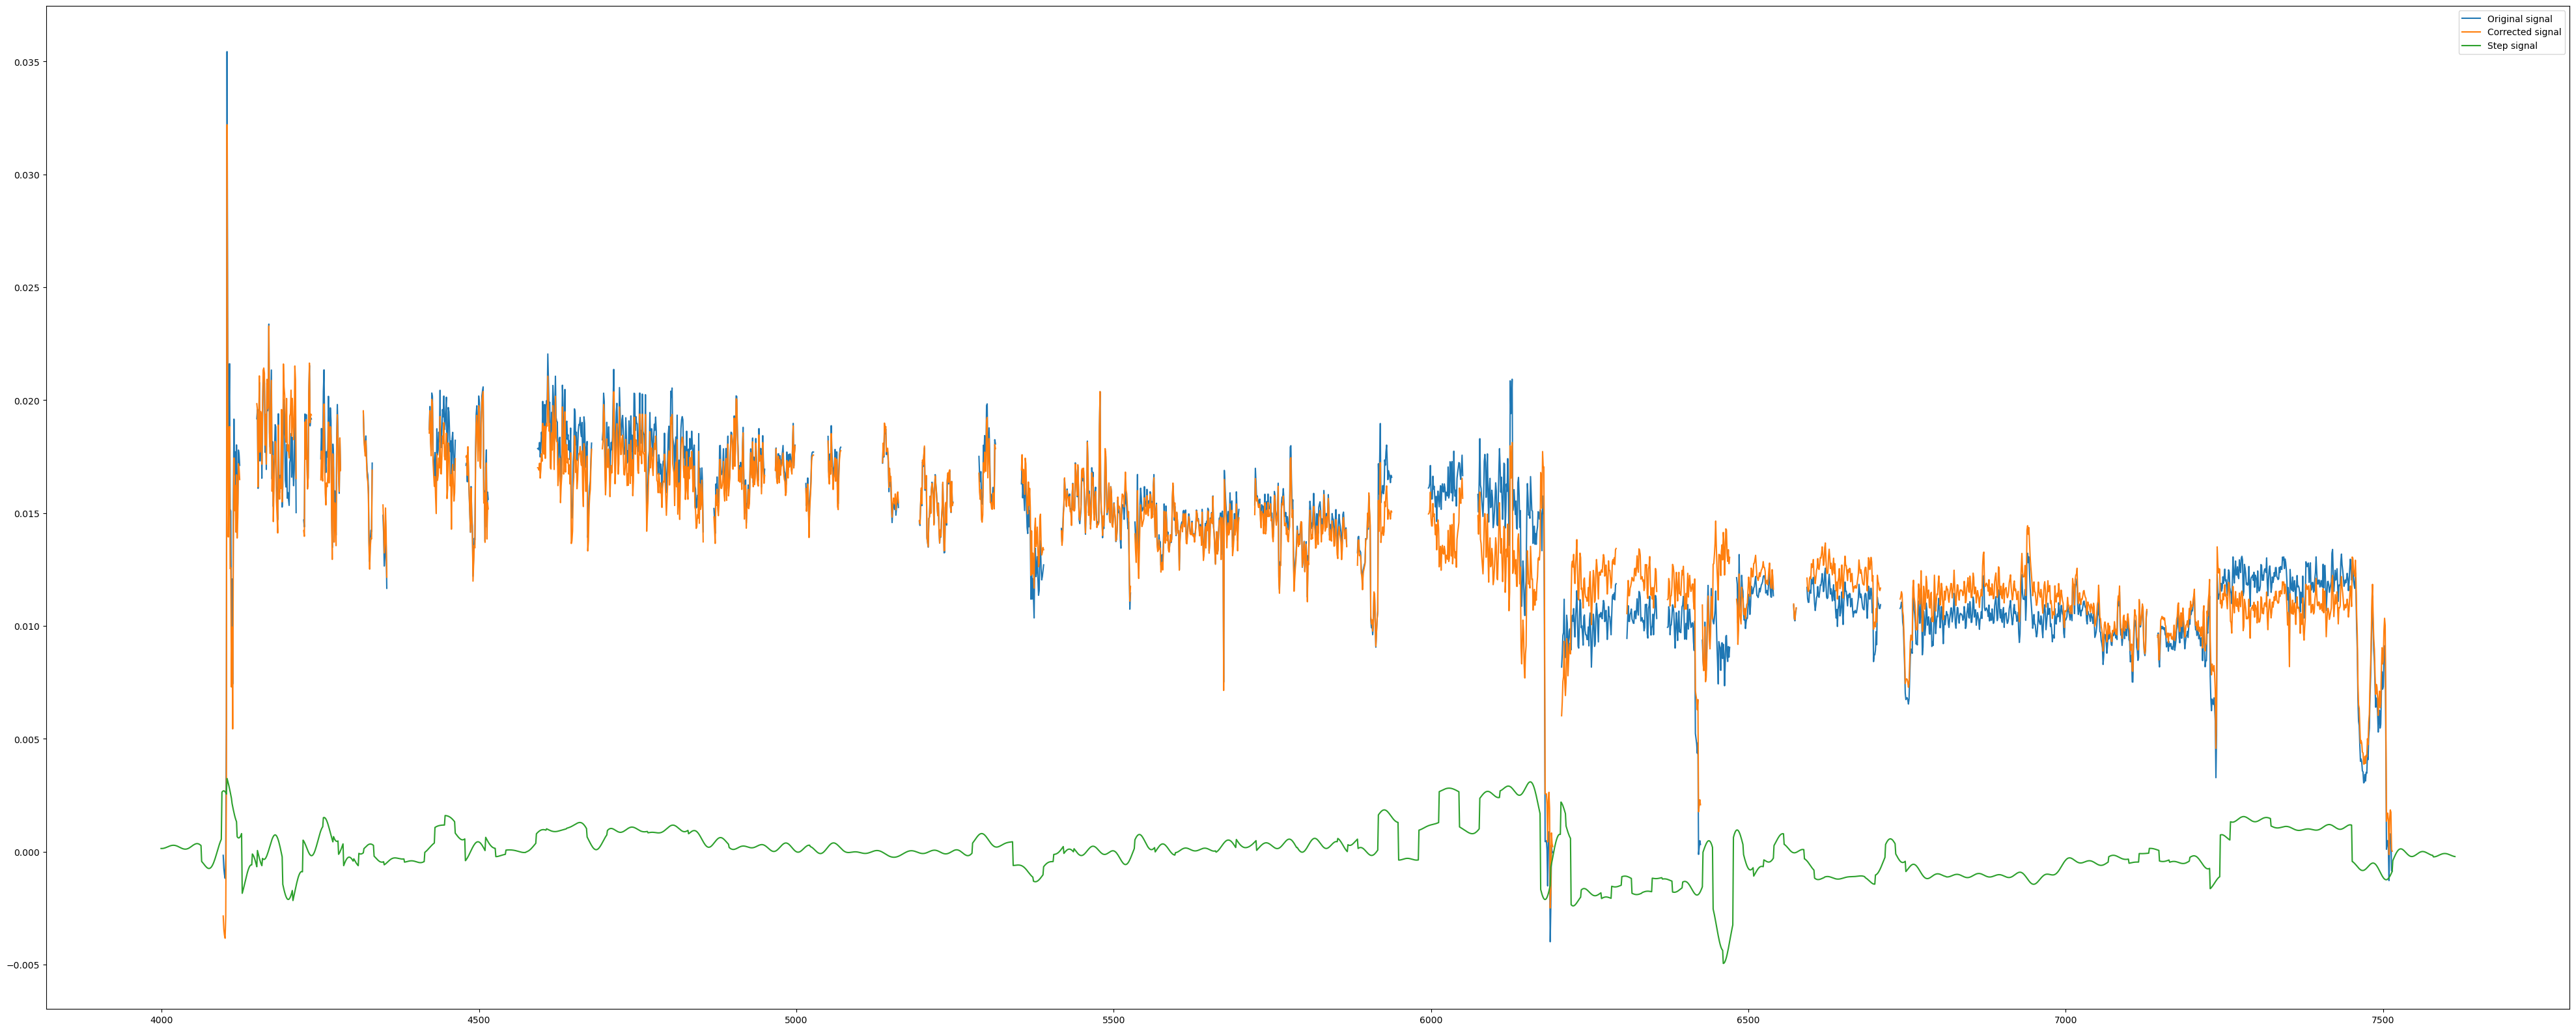

In [54]:
beam = 37
plt.figure(figsize=(50, 20))
plt.plot(
    data.corrected_wl,  # [: len(sythetic_data)],
    data.noise_subtracted_source[beam],  # [: len(sythetic_data)],
    label="Original signal",
)
plt.plot(
    data.corrected_wl,  # [: len(sythetic_data)],
    step_free_source[beam],  # [: len(sythetic_data)],
    label="Corrected signal",
)
plt.plot(
    data.corrected_wl,  # [: len(sythetic_data)],
    step_total[beam],  # [: len(sythetic_data)],
    label="Step signal",
)
plt.legend()

plt.show()

In [55]:
create_corrected_file(science, mdf, step_free_source, name)

corrected data saved at: redux/gsn069_pca_combined_spectra_ext.fits


### eRO-QPE2

In [3]:
object_name = list(sci_files_object_mapping.keys())[0]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_combined_spectra_ext.fits"
print(filename)
redshift = 0.0175
delta = 8

with fits.open(filename) as hdul:
    science = hdul["SCI"].data
    mdf = hdul["MDF"].data

wl = get_wl(filename, redshift)

redux/ero-qpe2_combined_spectra_ext.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
delta = 8

emission_lines = [
    4340.46,  # Hγ
    4363.21,  # [O III]
    4861.33,  # Hβ
    4958.91,  # [O III]
    5006.84,  # [O III]
    5875.6,  # [He I]
    6300.30,  # [O I]
    6363.78,  # [O I]
    6548.05,  # [N II]
    6562.79,  # Hα
    6583.45,  # [N II]
    6716.44,  # [S II]
    6730.82,  # [S II]
    7135.8,  # [Ar III]
]

# inspect_velocity_redshift_emission(science, wl, mdf, emission_lines, delta)

In [5]:
absortion_windows = [
    (4124, 4150),
    (4282, 4317),
    (4370, 4421),
    (4515, 4592),
    (5028, 5050),
    (5070, 5135),
    (5161, 5193),
    (5247, 5287),
    (5314, 5354),
    (5390, 5417),
    (5698, 5722),
    (5938, 5995),
    (6050, 6073),
]


# inspect_velocity_redshift_absortion(
#     science, wl, mdf, emission_lines, delta, absortion_windows
# )

In [6]:
pca_selection_criteria = "Coef."


data = SpectralPCA(
    filename,
    redshift,
    emission_lines,
    delta,
    absortion_windows,
)


data.pca_decompose()


data.luminosity_component_correlation(pca_selection_criteria)

x1     1.321164
x3     0.038582
x5     0.035090
x6     0.014167
x18    0.013732
x11    0.010882
x9     0.008498
x14    0.008490
x8     0.008192
x7     0.007285
x10    0.005420
x17    0.005049
x15    0.004379
x16    0.002475
x12    0.001809
x13    0.001202
x20    0.001072
x19    0.000603
x2     0.000434
x4     0.000329
Name: Coef., dtype: float64


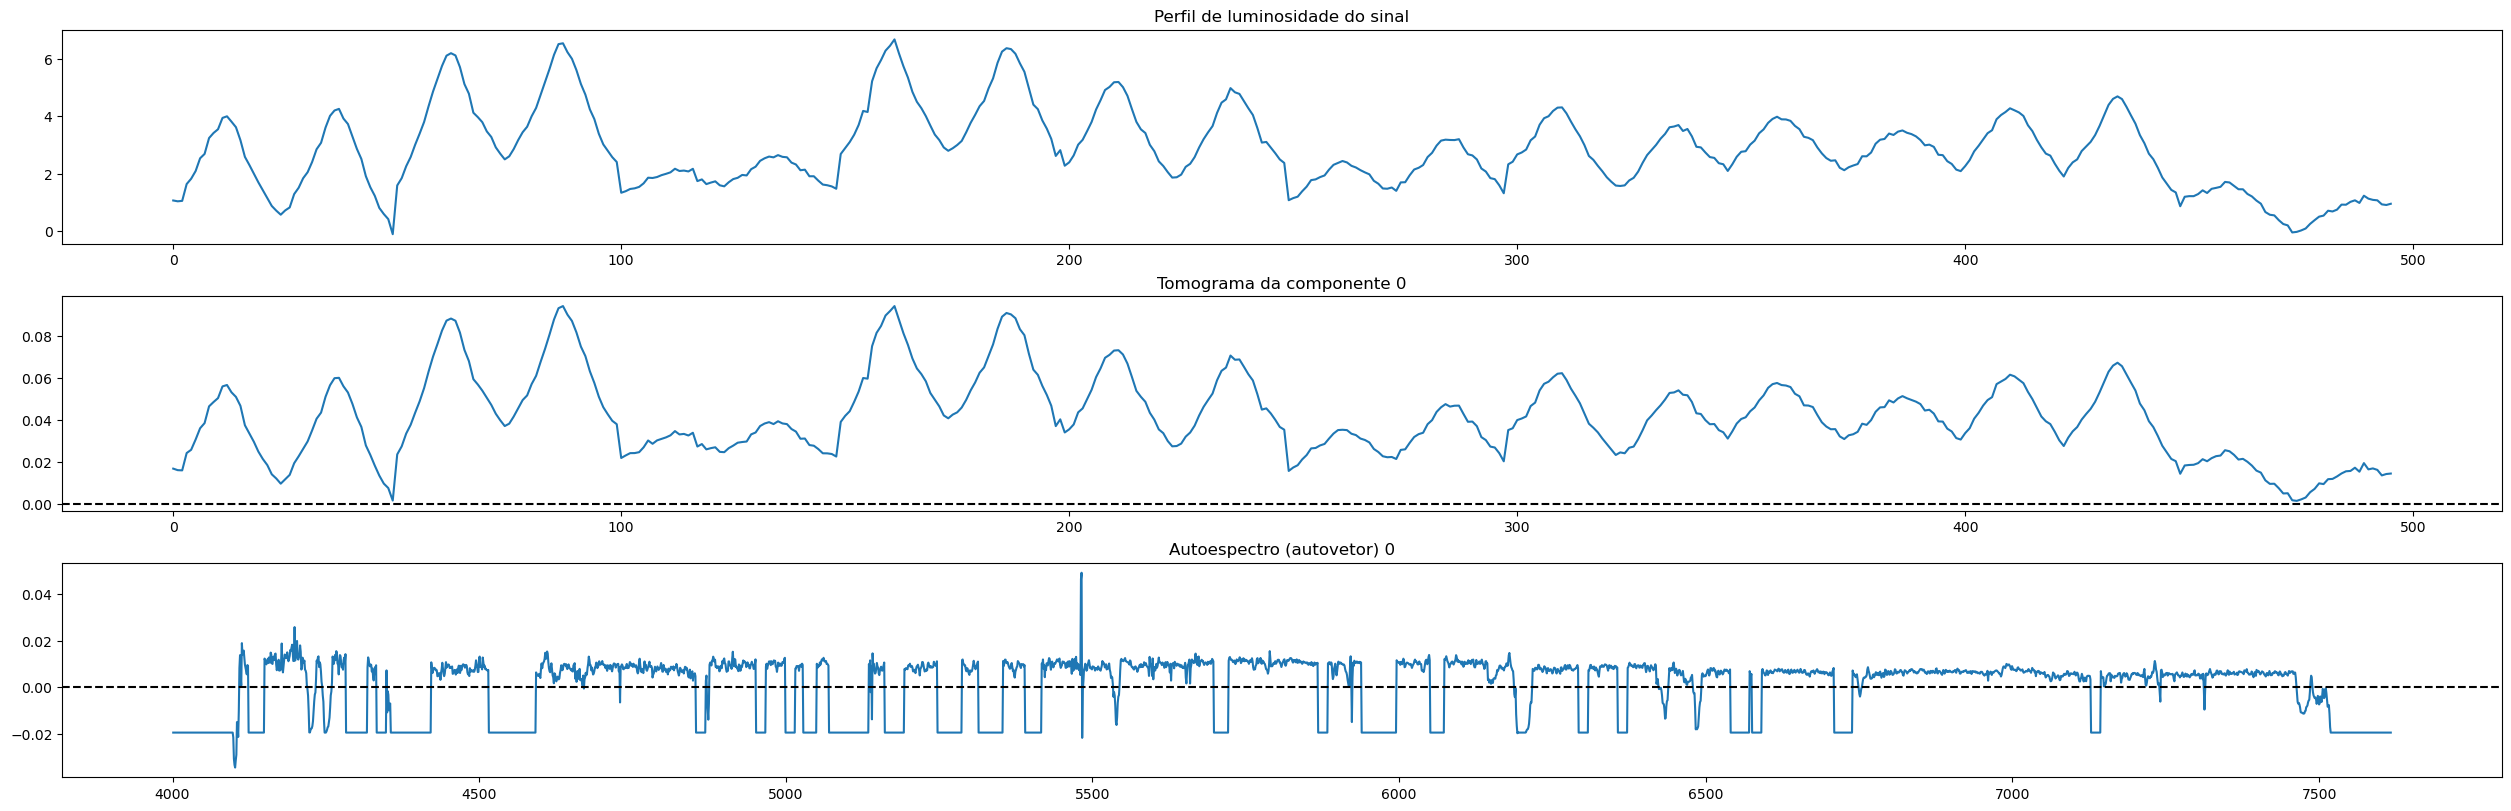

In [7]:
data.tomography(0)

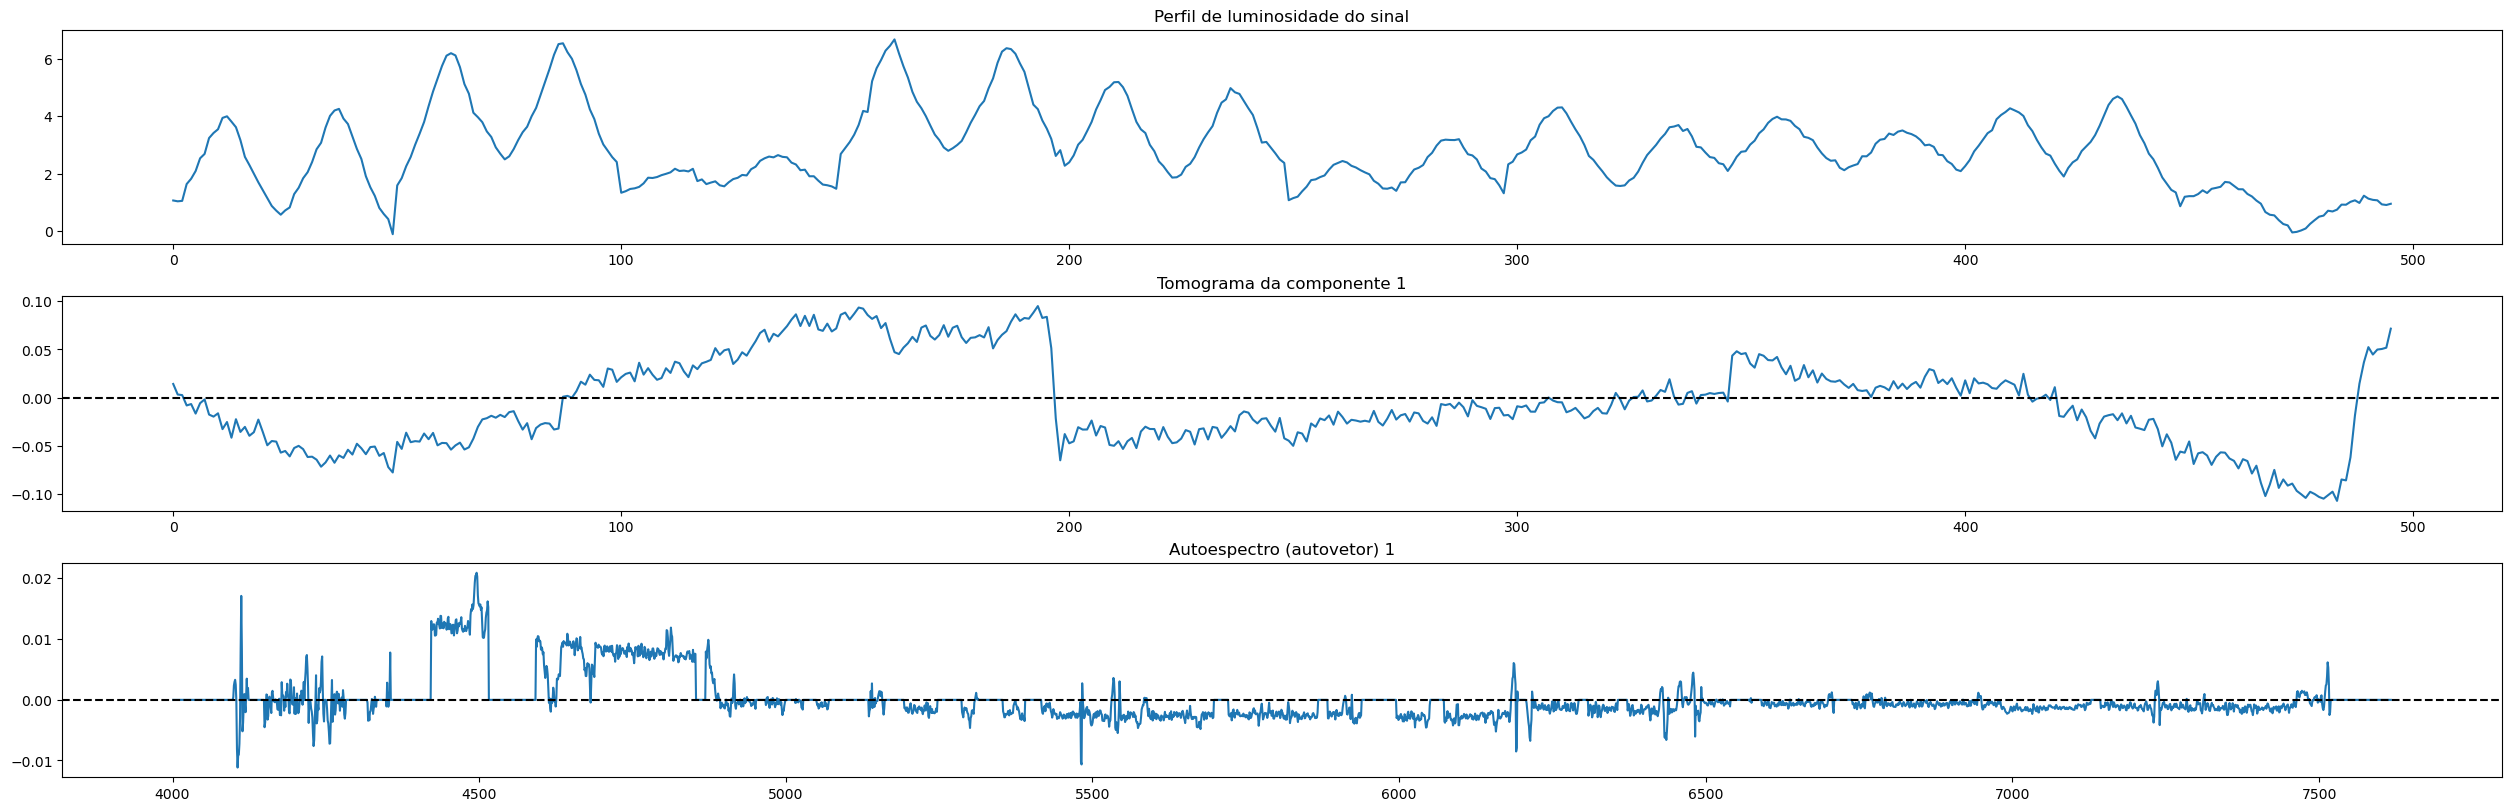

In [7]:
component = 1
data.tomography(component)

193


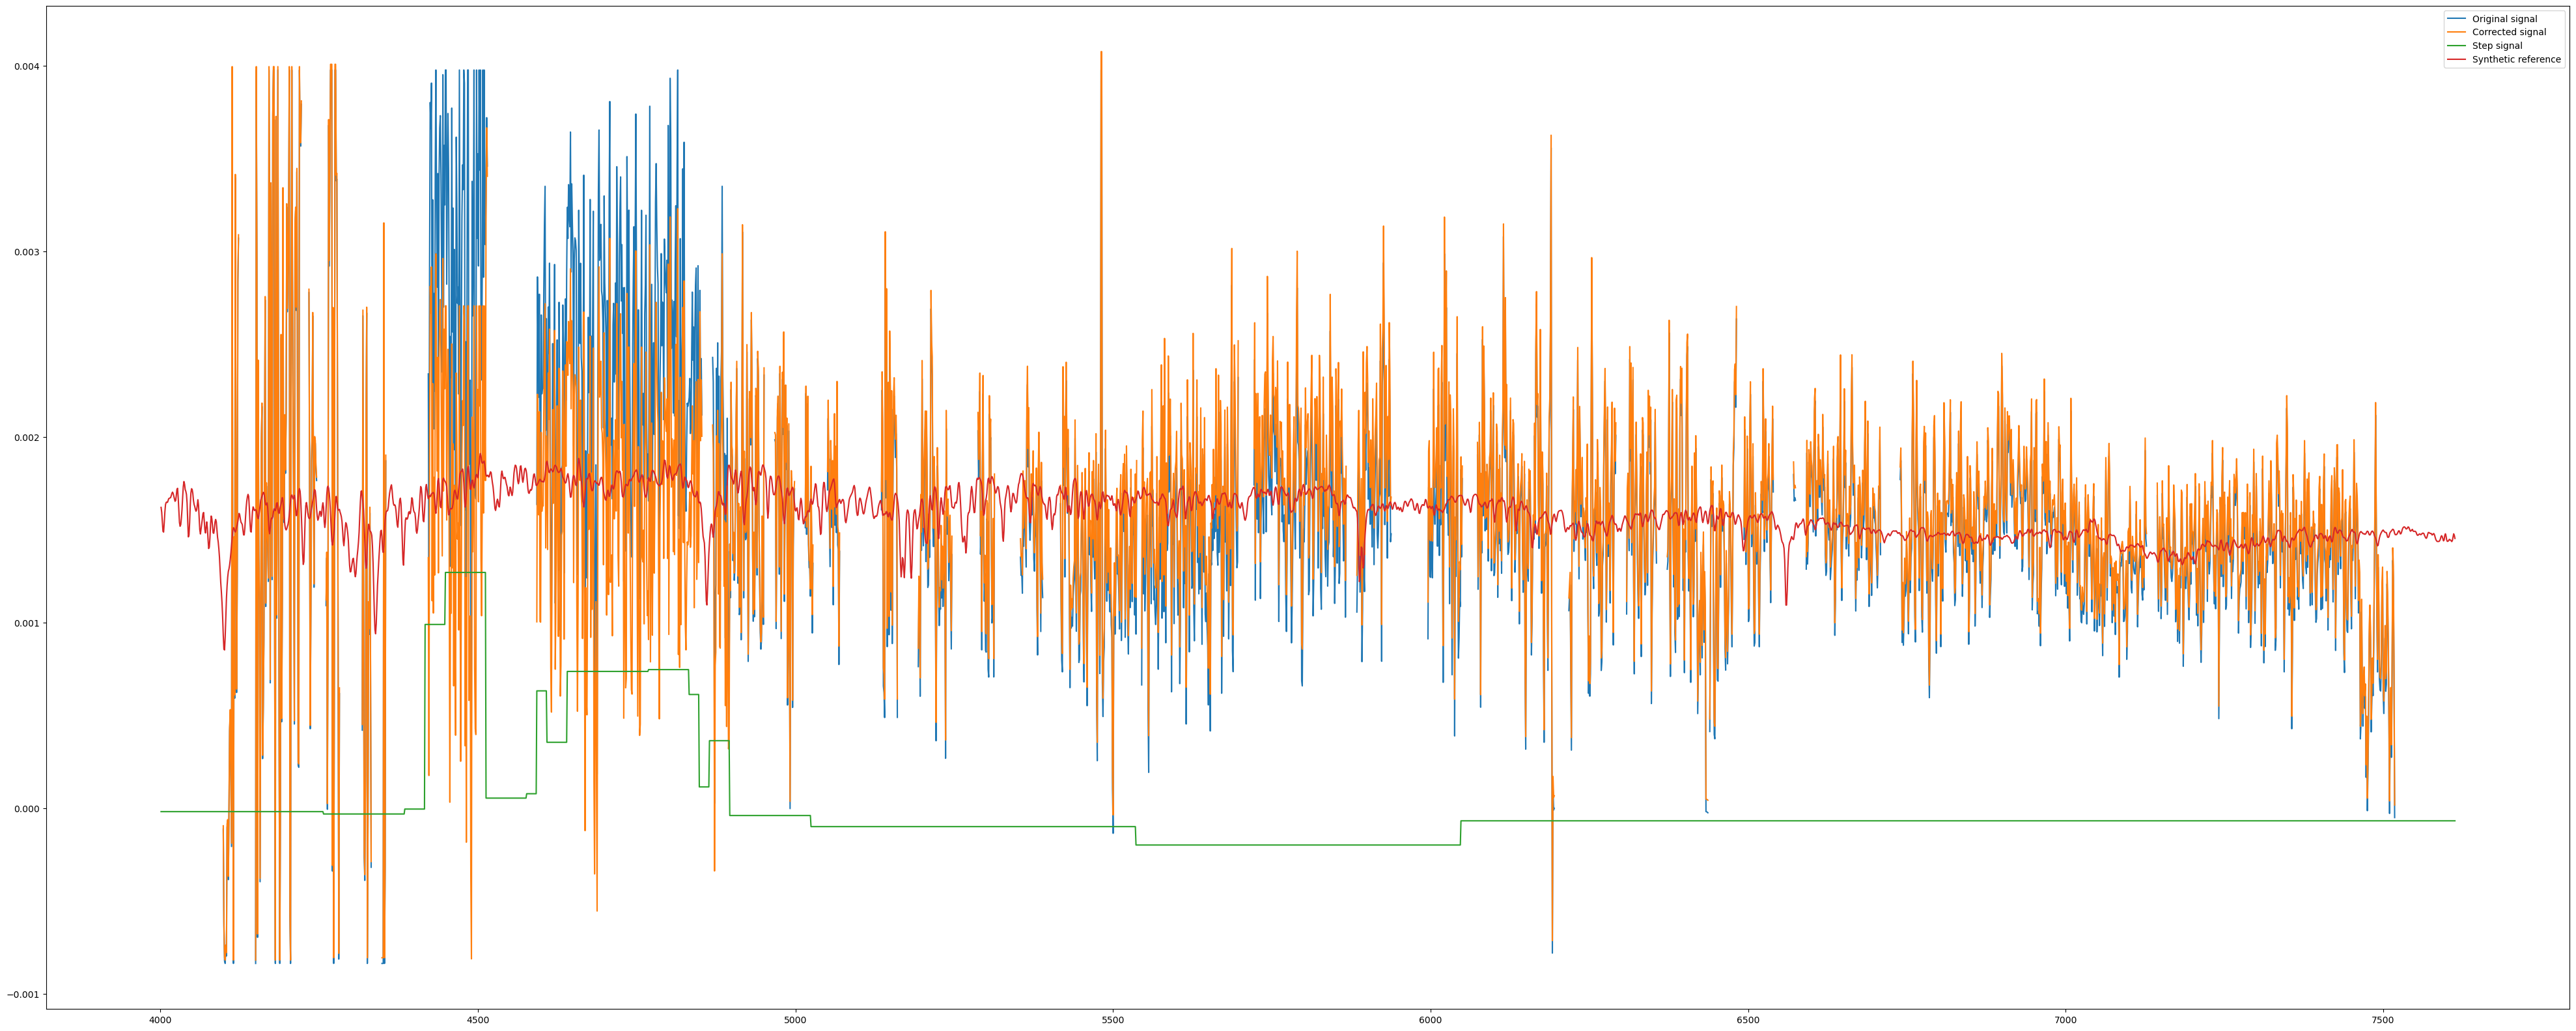

In [29]:
fft_filter = 1700
wavelet_filter = 4

beam = np.where(data.tomograms[component] == np.sort(data.tomograms[component])[-1])[0][
    0
]
print(beam)  # escolhe fibra em que o comp. tem a grande intensidade
stepfilter1 = data.StepSignalRemoval(component, noise_subtracted=False)
stepfilter1.calculate_and_subtract_step_signal(fft_filter, wavelet_filter)
stepfilter1.plot_step_sp_fit(beam)